# Digit Eye


In [148]:
%load_ext autoreload
%autoreload 2
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import DataLoader, Dataset

from src.models import Cifar10Model
from src.models.common.types import EpochResult

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
transform_normalization = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding = 4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transform_normalization
])
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transform_normalization
    ]
)

train_set = torchvision.datasets.CIFAR10( root="./assets/data", train = True, download = True, transform=train_transform)
test_set = torchvision.datasets.CIFAR10( root="./assets/data", train = False, download = True, transform=test_transform)


batch_size = 128
train_loader = DataLoader(
    dataset=train_set, batch_size=batch_size, shuffle=True
)
test_loader = DataLoader(
    dataset=test_set, batch_size=batch_size, shuffle=False
)

Files already downloaded and verified
Files already downloaded and verified


In [150]:
model_path = "./assets/digit_eye"
model = Cifar10Model(path=model_path)

train_history: None | list[EpochResult] = None
train_history = model.train(epochs=10, train_loader=train_loader, test_loader=test_loader)

model.load_weights()
model.evaluate(test_loader)


N° Epoch 0
Trainning loss: 0.011149795280694961	Accuracy: 0.47488
Test loss: 0.008568372279405594	Accuracy: 0.6093
Better Accuracy Found: -inf -> 0.6093. Saving Model...

N° Epoch 1
Trainning loss: 0.007085316588878632	Accuracy: 0.67746
Test loss: 0.006620120072364807	Accuracy: 0.7148
Better Accuracy Found: 0.6093 -> 0.7148. Saving Model...

N° Epoch 2
Trainning loss: 0.005718050705194474	Accuracy: 0.7418
Test loss: 0.005787640643119812	Accuracy: 0.7502
Better Accuracy Found: 0.7148 -> 0.7502. Saving Model...

N° Epoch 3
Trainning loss: 0.004947810808420181	Accuracy: 0.7797
Test loss: 0.005059434899687767	Accuracy: 0.7801
Better Accuracy Found: 0.7502 -> 0.7801. Saving Model...

N° Epoch 4
Trainning loss: 0.004462755046486855	Accuracy: 0.79954
Test loss: 0.004873600375652314	Accuracy: 0.7913
Better Accuracy Found: 0.7801 -> 0.7913. Saving Model...

N° Epoch 5
Trainning loss: 0.004054136018157005	Accuracy: 0.81996
Test loss: 0.00437948015332222	Accuracy: 0.813
Better Accuracy Found: 0.

{'accuracy': 0.8379, 'average_loss': 0.0036598200857639314}

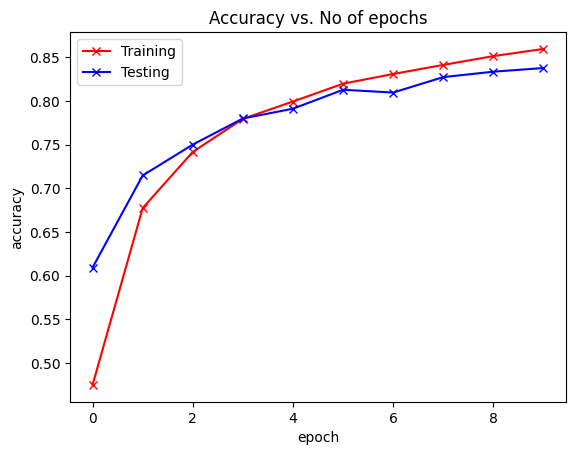

In [151]:
def plot_accuracies(history: list[EpochResult]):
    testing_accuracies = [x["testing"]["accuracy"] for x in history]
    training_accuracies = [x["training"]["accuracy"] for x in history]

    plt.plot(training_accuracies, "-rx")
    plt.plot(testing_accuracies, "-bx")

    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend(["Training", "Testing"])
    plt.title("Accuracy vs. No of epochs")

if train_history:
    plot_accuracies(train_history)

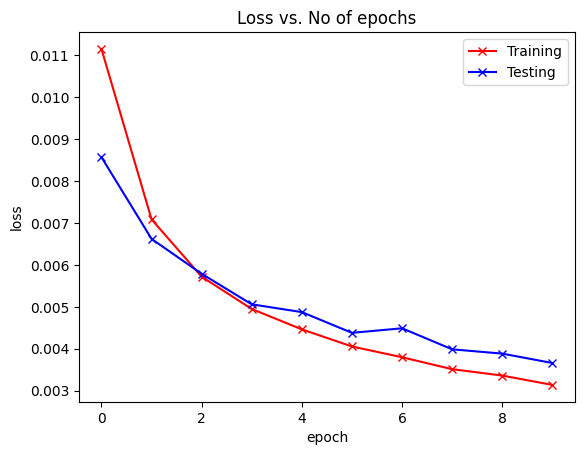

In [152]:
def plot_losses(history: list[EpochResult]):
    training_losses = [x['training']['average_loss'] for x in history]
    testing_losses = [x['testing']['average_loss'] for x in history]


    plt.plot(training_losses, "-rx")
    plt.plot(testing_losses, "-bx")

    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training", "Testing"])
    plt.title("Loss vs. No of epochs")

if train_history:
    plot_losses(train_history)

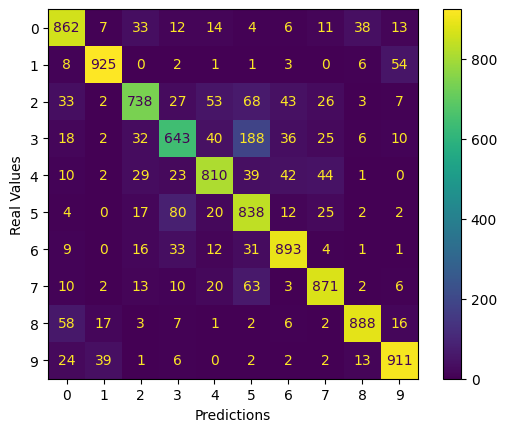

In [153]:
def plot_preds(model: Cifar10Model):
    y_pred = []
    y_true = []

    for batch in test_loader:
        batch_step = model.batch_step(batch)
        y_pred.extend(batch_step["preds"])
        y_true.extend(batch[1].data)

    y_pred = [y.item() for y in y_pred]
    y_true = [y.item() for y in y_true]

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    
    plt.xlabel("Predictions")
    plt.ylabel("Real Values")
    plt.show()

plot_preds(model)

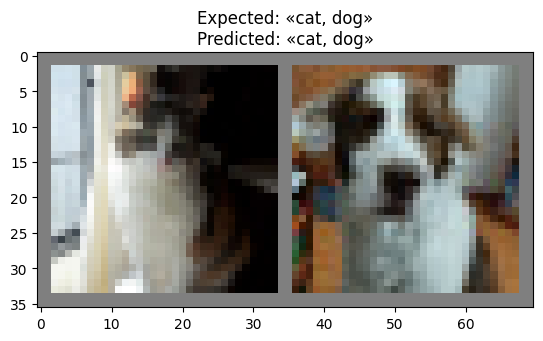

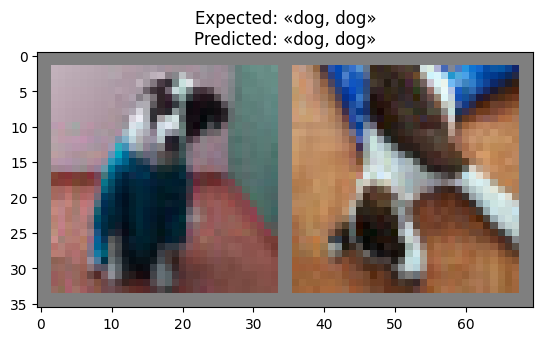

In [155]:
from typing import Dict, List, Tuple


def get_img_title(expected_values: torch.Tensor, predicted_values: torch.Tensor):
    classes: dict[int, str] = dict(map(reversed, train_set.class_to_idx.items()))  # type: ignore
    return f"Expected: «{', '.join(classes[x] for x in expected_values.tolist())}»\nPredicted: «{', '.join(classes[x] for x in predicted_values.tolist())}»"


def imshow(img: torch.Tensor, expected_values: torch.Tensor, predicted_values: torch.Tensor):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.title(get_img_title(expected_values, predicted_values))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


class CustomImageFolder(torchvision.datasets.ImageFolder):
    def find_classes(self, directory: str) -> Tuple[List[str], Dict[str, int]]:
        class_to_idx = {"cat": 3, "dog": 5}
        classes = list(class_to_idx.keys())
        return classes, class_to_idx


custom_set = CustomImageFolder(root="./assets/images", transform=test_transform)

custom_loader = DataLoader(custom_set, batch_size=2)

for batch in custom_loader:
    images, labels = batch
    batch_step = model.batch_step(batch)
    imshow(torchvision.utils.make_grid(images), labels, batch_step["preds"])
